<a href="https://colab.research.google.com/github/nandhukumar86/CapstonePneumoniaDetection/blob/main/PnemoniaDetectionModel_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline
import cv2
import skimage.io as io
import os
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import Conv2D, Concatenate, Reshape, UpSampling2D
import pickle
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.losses import binary_crossentropy
import gc
from tensorflow.keras.applications import DenseNet121, DenseNet201
from tensorflow.keras.applications import VGG16
from google.colab.patches import cv2_imshow
from tensorflow import reduce_sum
from tensorflow.keras.backend import log,epsilon
 
from sklearn.model_selection import train_test_split

In [2]:
file = open('/content/drive/MyDrive/CapstoneDataSet/dataset/RezisedLabel-1.pickle', 'rb')
dfData = pickle.load(file)
file.close()

In [3]:
# dfData_0 = dfData[dfData['Target'] == 0].sample(9555)
# dfData_1 = dfData[dfData['Target'] == 1].sample(9555)
 
# dfData = pd.concat([dfData_0, dfData_1], axis=0, ignore_index=True)
 
dfData = dfData.sample(frac=1)

In [4]:
X = []
y_classify = []
y_segment = []
 
i = 0
for pId in dfData['patientId'].unique():
  data = dfData[dfData['patientId'] == pId][['Image256','xo','yo','widtho','heighto','Target']]
  pData = cv2.cvtColor(cv2.resize(data.iloc[0][0],(256,256)), cv2.COLOR_BAYER_GR2RGB)
  X.append(pData)
  mask = np.zeros((256,256))
  if (data.iloc[0][5] == 1):
    j = 0
    for segment in range(data.shape[0]):
      xo = int(data.iloc[j][1])
      yo = int(data.iloc[j][2])
      wo = int(data.iloc[j][1] + data.iloc[j][3])
      ho = int(data.iloc[j][2] + data.iloc[j][4])
      mask = cv2.rectangle(mask,(xo, yo),(wo, ho),(255,0,0),-1)
      j = j+1
  y_classify.append(data.iloc[0][5])
  fmask = np.array(cv2.resize(mask,(64,64)),'float16')
  y_segment.append(np.array([fmask.T, fmask.T, fmask.T]).T)
  if (i%1000 == 0):
    print(i, " completed")
  i = i + 1

0  completed
1000  completed
2000  completed
3000  completed
4000  completed
5000  completed
6000  completed
7000  completed
8000  completed
9000  completed
10000  completed
11000  completed
12000  completed
13000  completed
14000  completed
15000  completed
16000  completed
17000  completed
18000  completed
19000  completed
20000  completed
21000  completed
22000  completed
23000  completed
24000  completed
25000  completed
26000  completed


In [5]:
X_train, X_val, y_train_classify, y_val_classify, y_train_segment, y_val_segment = \
train_test_split(X, y_classify, y_segment, test_size=0.30, random_state=100)

In [6]:
tensorflow.keras.backend.clear_session()

In [7]:
iLayer = tensorflow.keras.Input(shape=(256,256,3), name='customInputLayer')
x = tensorflow.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)(iLayer)
oLayer = DenseNet121(include_top=False,weights='imagenet', input_tensor=x,input_shape=(256,256,3))
 
model = Model(iLayer,oLayer.output)
 
pcTrainableLayers = 0.9
 
lengthLayers = len(model.layers)
pcLayers = int(pcTrainableLayers * lengthLayers)
for i in range(pcLayers):
  model.layers[i].trainable = False

In [8]:
layer8x8 = model.get_layer('conv5_block16_2_conv').output
layer16x16 = model.get_layer('conv4_block24_2_conv').output
layer32x32 = model.get_layer('conv3_block12_2_conv').output
layer64x64 = model.get_layer('conv2_block6_2_conv').output
 
output_segment = Concatenate()([UpSampling2D()(layer8x8), layer16x16])
output_segment = Concatenate()([UpSampling2D()(output_segment), layer32x32])
output_segment = Concatenate()([UpSampling2D()(output_segment), layer64x64])
output_segment = Conv2D(16, kernel_size = 1,activation='relu')(output_segment)
output_segment = Conv2D(7, kernel_size = 1,activation='relu')(output_segment)
output_segment = Conv2D(3, kernel_size = 1,activation='relu')(output_segment)
output_segment = Reshape((64, 64, 3), name='output_segment')(output_segment)
 
 
output_classify = Concatenate()([UpSampling2D()(layer8x8), layer16x16])
output_classify = Concatenate()([UpSampling2D()(output_classify), layer32x32])
output_classify = Concatenate()([UpSampling2D()(output_classify), layer64x64])
output_classify = Flatten()(output_classify)
output_classify = Dropout(0.8)(output_classify)
output_classify = Dense(2, activation='softmax', name='output_classify')(output_classify)
 
model = Model(model.input, [output_classify, output_segment])

In [9]:
# X_train = preprocess_input(np.array(X_train))
# X_val = preprocess_input(np.array(X_val))
 
X_train = np.array(X_train)
X_val = np.array(X_val)
 
y_train_classify = np.array(y_train_classify)
y_val_classify = np.array(y_val_classify)
 
y_train_classify = np.array([y_train_classify, ~y_train_classify+2]).T
y_val_classify = np.array([y_val_classify, ~y_val_classify+2]).T
 
y_train_segment = np.array(y_train_segment)
y_val_segment = np.array(y_val_segment)

In [10]:
print('Train Data: ',X_train.shape, y_train_classify.shape, y_train_segment.shape)
print('Validation Data: ',X_val.shape, y_val_classify.shape, y_val_segment.shape)

Train Data:  (18678, 256, 256, 3) (18678, 2) (18678, 64, 64, 3)
Validation Data:  (8006, 256, 256, 3) (8006, 2) (8006, 64, 64, 3)


In [11]:
losses = {
    "output_segment" : "mean_squared_error",
    "output_classify" : "categorical_crossentropy"
}
 
metrics = {
    "output_segment" : "mse",
    "output_classify" : "accuracy"
}
 
model.compile(loss = losses, optimizer='adam', metrics = metrics)
 
hist = model.fit(
    x = X_train, 
    y = {"output_classify": y_train_classify, "output_segment": y_train_segment}, 
    epochs=20, 
    batch_size=16, 
    validation_data=(X_val, {"output_classify": y_val_classify, "output_segment" : y_val_segment }), 
    verbose=1)

Epoch 1/20
1168/1168 [==============================] - 79s 49ms/step - loss: 1440.8457 - output_classify_loss: 13.4440 - output_segment_loss: 1427.3999 - output_classify_accuracy: 0.7597 - output_segment_mse: 1427.3999 - val_loss: 1251.5641 - val_output_classify_loss: 6.8190 - val_output_segment_loss: 1244.7465 - val_output_classify_accuracy: 0.7738 - val_output_segment_mse: 1244.7465
Epoch 2/20
1168/1168 [==============================] - 54s 46ms/step - loss: 1261.9874 - output_classify_loss: 13.0324 - output_segment_loss: 1248.9556 - output_classify_accuracy: 0.7815 - output_segment_mse: 1248.9556 - val_loss: 1222.3881 - val_output_classify_loss: 7.7474 - val_output_segment_loss: 1214.6405 - val_output_classify_accuracy: 0.7818 - val_output_segment_mse: 1214.6405
Epoch 3/20
1168/1168 [==============================] - 53s 46ms/step - loss: 1217.6953 - output_classify_loss: 11.7252 - output_segment_loss: 1205.9697 - output_classify_accuracy: 0.7906 - output_segment_mse: 1205.9697 - 

In [12]:
classify_result, segment_result = model.predict(X_train)

1


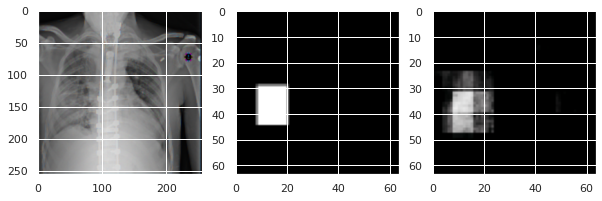

In [13]:
n = int(np.random.rand(1)[0]*X_train.shape[0])
 
fig, axes = plt.subplots(1,3,figsize=(10,10))
axes[0].imshow(X_train[n])
axes[1].imshow(y_train_segment[n].astype('int'));
axes[2].imshow(segment_result[n].astype('int'))
 
print(~classify_result[n].argmax()+2)

In [40]:
segment_result[n].min()

0.33210918

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


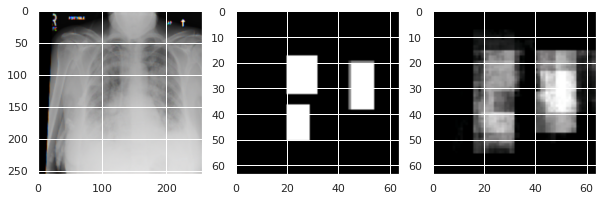

In [21]:
n = int(np.random.rand(1)[0]*X_train.shape[0])

fig, axes = plt.subplots(1,3,figsize=(10,10))
axes[0].imshow(X_train[n])
axes[1].imshow(y_train_segment[n].astype('int'));
axes[2].imshow(segment_result[n].astype('int'))

print(~classify_result[n].argmax()+2)

1


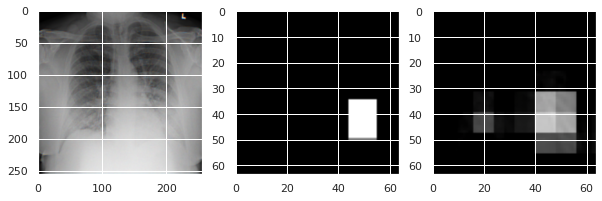

In [ ]:
n = int(np.random.rand(1)[0]*X_train.shape[0])

fig, axes = plt.subplots(1,3,figsize=(10,10))
axes[0].imshow(X_train[n])
axes[1].imshow(y_train_segment[n].astype('int'));
axes[2].imshow(segment_result[n].astype('int'))

print(~classify_result[n].argmax()+2)

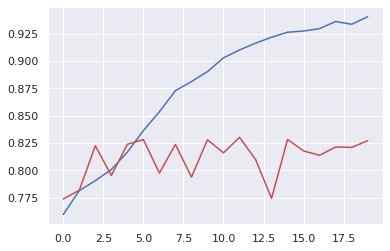

In [22]:
epochs = range(len(hist.history['output_segment_loss']))
plt.plot(epochs, hist.history['output_classify_accuracy'],'b', label = 'Accuracy')
plt.plot(epochs, hist.history['val_output_classify_accuracy'],'r', label = 'Accuracy')

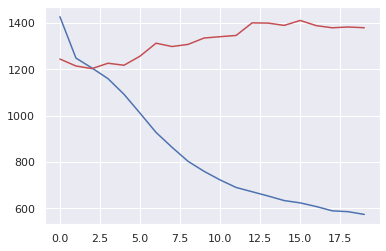

In [23]:
epochs = range(len(hist.history['output_segment_loss']))
plt.plot(epochs, hist.history['output_segment_mse'],'b', label = 'Mean Squared Error')
plt.plot(epochs, hist.history['val_output_segment_mse'],'r', label = 'Mean Squared Error')

In [ ]:
model.save('/content/drive/MyDrive/CapstoneDataSet/modelPickle/model-dn.h5')

In [ ]:
model_1 = tensorflow.keras.models.load_model('/content/drive/MyDrive/CapstoneDataSet/modelPickle/model-dn.h5')